--- df_route_segments DataFrame loaded successfully ---
   segment_id  driver_id segment_type  order_id   segment_start_time  \
0           0          4         STOP    1312.0  2024-02-09 14:58:42   
1           1          4        DRIVE       NaN  2024-02-09 14:51:20   
2           2          4         STOP    1273.0  2024-02-24 09:26:31   
3           3          4        DRIVE       NaN  2024-02-24 09:15:02   
4           4          1         STOP    1036.0  2024-02-24 20:26:23   

      segment_end_time  
0  2024-02-09 15:01:56  
1  2024-02-09 14:55:42  
2  2024-02-24 09:32:12  
3  2024-02-24 09:23:31  
4  2024-02-24 20:26:23  

--- Data Types (dtypes) before conversion ---
segment_id              int64
driver_id               int64
segment_type           object
order_id              float64
segment_start_time     object
segment_end_time       object
dtype: object

--- Data Types (dtypes) after time conversion ---
segment_id                     int64
driver_id                      i

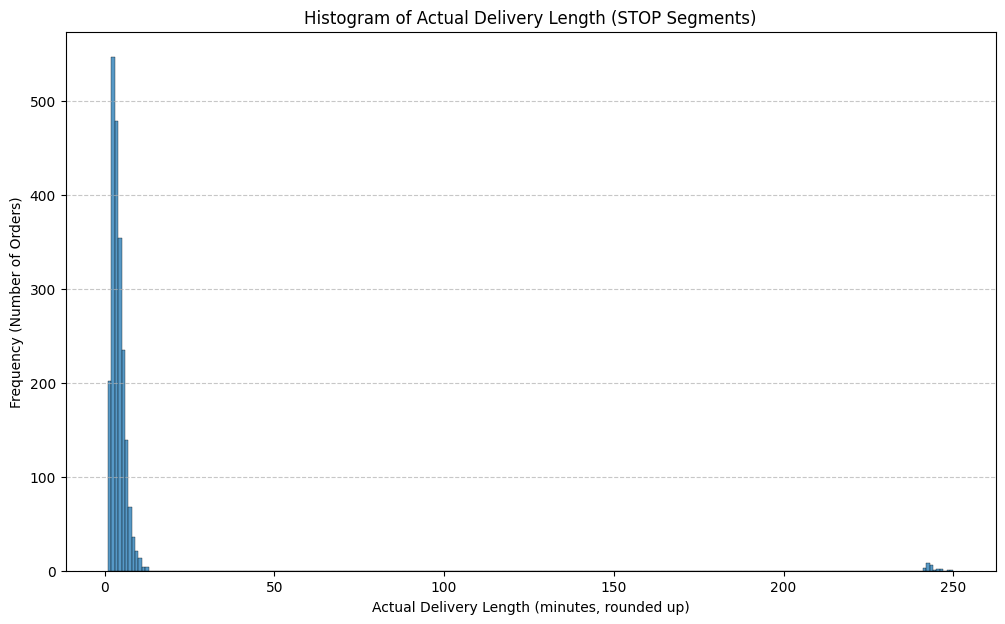

<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load the route_segments.csv file ---
try:
    df_route_segments = pd.read_csv("data/route_segments.csv", na_values=["\\N"])

    print("--- df_route_segments DataFrame loaded successfully ---")
    print(df_route_segments.head())
    print("\n--- Data Types (dtypes) before conversion ---")
    print(df_route_segments.dtypes)

    # --- Convert timestamp columns to datetime objects ---
    df_route_segments["segment_start_time"] = pd.to_datetime(
        df_route_segments["segment_start_time"], errors="coerce"
    )
    df_route_segments["segment_end_time"] = pd.to_datetime(
        df_route_segments["segment_end_time"], errors="coerce"
    )

    print("\n--- Data Types (dtypes) after time conversion ---")
    print(df_route_segments.dtypes)
    print("\n--- df_route_segments head after time conversion ---")
    print(df_route_segments.head())

    df_stops = df_route_segments[
        (df_route_segments["segment_type"] == "STOP")
        & (df_route_segments["order_id"].notna())
        & (df_route_segments["segment_start_time"].notna())
        & (df_route_segments["segment_end_time"].notna())
    ].copy()  # Use .copy() to avoid SettingWithCopyWarning

    if not df_stops.empty:
        # --- Calculate actual delivery duration in seconds ---
        df_stops["actual_delivery_duration_seconds"] = (
            df_stops["segment_end_time"] - df_stops["segment_start_time"]
        ).dt.total_seconds()

        print(
            "\n--- Initial Data Statistics for 'actual_delivery_duration_seconds' ---"
        )
        print(df_stops["actual_delivery_duration_seconds"].describe())

        non_positive_durations = df_stops[
            df_stops["actual_delivery_duration_seconds"] <= 0
        ]
        print(
            f"\nNumber of STOP deliveries with non-positive duration: {len(non_positive_durations)}"
        )
        if not non_positive_durations.empty:
            print("Examples of non-positive durations:")
            print(
                non_positive_durations[
                    [
                        "order_id",
                        "segment_start_time",
                        "segment_end_time",
                        "actual_delivery_duration_seconds",
                    ]
                ].head()
            )
            df_stops = df_stops[df_stops["actual_delivery_duration_seconds"] > 0].copy()
            print(
                f"Filtered out non-positive durations. New record count for STOP segments: {len(df_stops)}"
            )

        long_duration_threshold_seconds = 7200
        long_durations = df_stops[
            df_stops["actual_delivery_duration_seconds"]
            > long_duration_threshold_seconds
        ]
        print(
            f"\nNumber of STOP deliveries over {long_duration_threshold_seconds / 3600:.1f} hours: {len(long_durations)}"
        )
        if not long_durations.empty:
            print("Examples of very long durations:")
            print(
                long_durations[["order_id", "actual_delivery_duration_seconds"]].head()
            )
        # --- Convert to Minutes and Round Up ---
        df_stops["actual_delivery_duration_minutes_rounded_up"] = np.ceil(
            df_stops["actual_delivery_duration_seconds"] / 60
        )

        print(
            "\n--- Data Statistics for 'actual_delivery_duration_minutes_rounded_up' ---"
        )
        print(df_stops["actual_delivery_duration_minutes_rounded_up"].describe())

        # --- Generate the Histogram ---
        plt.figure(figsize=(12, 7))
        upper_limit_visualization = df_stops[
            "actual_delivery_duration_minutes_rounded_up"
        ].quantile(0.99)
        if upper_limit_visualization < 60:
            upper_limit_visualization = 60
        if upper_limit_visualization > 240:
            upper_limit_visualization = 240

        sns.histplot(
            data=df_stops,
            x="actual_delivery_duration_minutes_rounded_up",
            binwidth=1,
            kde=False,
        )
        plt.title("Histogram of Actual Delivery Length (STOP Segments)")
        plt.xlabel("Actual Delivery Length (minutes, rounded up)")
        plt.ylabel("Frequency (Number of Orders)")
        plt.grid(axis="y", linestyle="--", alpha=0.7)

        plt.show()

        # plt.savefig('histogram_actual_delivery_length.png', dpi=300)

    else:
        print("No valid 'STOP' segments found to calculate delivery durations.")

except FileNotFoundError:
    print(
        f"Error: 'route_segments.csv' not found. Please ensure the file is in the correct directory."
    )
except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
reasonable_upper_limit = 30

plt.figure(figsize=(12, 7))
sns.histplot(
    data=df_stops,
    x="actual_delivery_duration_minutes_rounded_up",
    binwidth=1,
    kde=False,
)
plt.title("Histogram of Actual Delivery Length (STOP Segments - Main Distribution)")
plt.xlabel("Actual Delivery Length (minutes, rounded up)")
plt.ylabel("Frequency (Number of Orders)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xlim(0, reasonable_upper_limit)  # Apply the limit
plt.xticks(ticks=range(0, int(reasonable_upper_limit) + 1, 2))
plt.show()
# plt.savefig('histogram_actual_delivery_length_main_dist.png', dpi=300)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

orders_cols = ["order_id", "customer_id", "sector_id", "planned_delivery_duration"]
try:
    df_orders = pd.read_csv(
        "data/orders.csv",
        na_values=["\\N"],  
    )
    print("--- df_orders DataFrame loaded successfully ---")
    print(df_orders.head())
    print("\n--- df_orders Data Types (dtypes) ---")
    print(df_orders.dtypes)

    df_orders["planned_delivery_duration"] = pd.to_numeric(
        df_orders["planned_delivery_duration"], errors="coerce"
    )
    if "actual_delivery_duration_seconds" not in df_stops.columns:
        print(
            "Error: 'actual_delivery_duration_seconds' not found in df_stops. Please re-run previous steps."
        )
    elif df_orders.empty:
        print("Error: df_orders is empty.")
    else:
        df_merged_errors = pd.merge(
            df_stops[["order_id", "actual_delivery_duration_seconds"]],
            df_orders[["order_id", "planned_delivery_duration"]],
            on="order_id",
            how="inner", 
        )

        print(f"\n--- Merged DataFrame for Error Calculation (df_merged_errors) ---")
        print(f"Number of records in df_stops (cleaned): {len(df_stops)}")
        print(f"Number of records in df_orders: {len(df_orders)}")
        print(f"Number of records after merge: {len(df_merged_errors)}")
        print(df_merged_errors.head())

        if df_merged_errors.empty:
            print(
                "Merge resulted in an empty DataFrame. Check 'order_id' values and presence in both tables."
            )
        else:
            # --- Calculate Prediction Error ---
            # Error = Planned - Actual.
            # Positive error: delivery was faster than planned (overestimation by planner).
            # Negative error: delivery was slower than planned (underestimation by planner).
            df_merged_errors["prediction_error_seconds"] = (
                df_merged_errors["planned_delivery_duration"]
                - df_merged_errors["actual_delivery_duration_seconds"]
            )

            # --- Analyze Prediction Error ---
            print("\n--- Statistics for 'prediction_error_seconds' ---")
            print(df_merged_errors["prediction_error_seconds"].describe())

            # Optional: Convert error to minutes for the histogram if preferred,
            # but calculations based on seconds are more precise initially.
            df_merged_errors["prediction_error_minutes"] = (
                df_merged_errors["prediction_error_seconds"] / 60
            )

            print("\n--- Statistics for 'prediction_error_minutes' ---")
            print(df_merged_errors["prediction_error_minutes"].describe())

            # --- Generate Histogram of Prediction Error ---
            plt.figure(figsize=(12, 7))
            sns.histplot(
                data=df_merged_errors,
                x="prediction_error_minutes",  # Or use 'prediction_error_seconds'
                # Choose a binwidth that makes sense for the range of errors.
                # If errors are mostly within +/- 60 minutes, a binwidth of 1-5 minutes might be good.
                binwidth=2,  # Example: 2-minute bins
                # You can also use 'bins=N' for a specific number of bins.
            )
            plt.title("Histogram of Prediction Error (Planned - Actual Delivery Time)")
            plt.xlabel("Prediction Error (minutes) [Positive = Faster than planned]")
            plt.ylabel("Frequency (Number of Orders)")
            plt.axvline(
                0,
                color="red",
                linestyle="--",
                linewidth=1.5,
                label="Perfect Prediction (Error = 0)",
            )
            plt.legend()
            plt.grid(axis="y", linestyle="--", alpha=0.7)

            # Consider setting x-limits if extreme error values skew the plot too much,
            # similar to the previous histogram.
            # error_lower_limit = df_merged_errors['prediction_error_minutes'].quantile(0.01)
            # error_upper_limit = df_merged_errors['prediction_error_minutes'].quantile(0.99)
            # plt.xlim(error_lower_limit, error_upper_limit)

            plt.show()
            # plt.savefig('histogram_prediction_error.png', dpi=300)
except FileNotFoundError:
    print(
        f"Error: 'orders.csv' not found. Please ensure the file is in the correct directory."
    )
except Exception as e:
    print(f"An error occurred: {e}")


--- Merged DataFrame for Sector Analysis (df_sector_times) ---
Number of records after merge: 2125
   order_id  actual_delivery_duration_minutes_rounded_up  sector_id
0    1312.0                                          4.0          1
1    1273.0                                          6.0          3
2    2178.0                                          2.0          3
3     331.0                                          3.0          3
4    2221.0                                          3.0          1

--- Delivery Time Statistics per Sector (Minutes, Rounded Up) ---
               mean  median  count        std  min    max
sector_id                                                
1          6.520863     4.0    695  22.479239  1.0  250.0
2          6.125180     3.0    695  27.150507  1.0  245.0
3          5.972789     3.0    735  26.374464  1.0  246.0


/tmp/ipykernel_6209/1699084526.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sector_summary = df_sector_times.groupby("sector_id")[


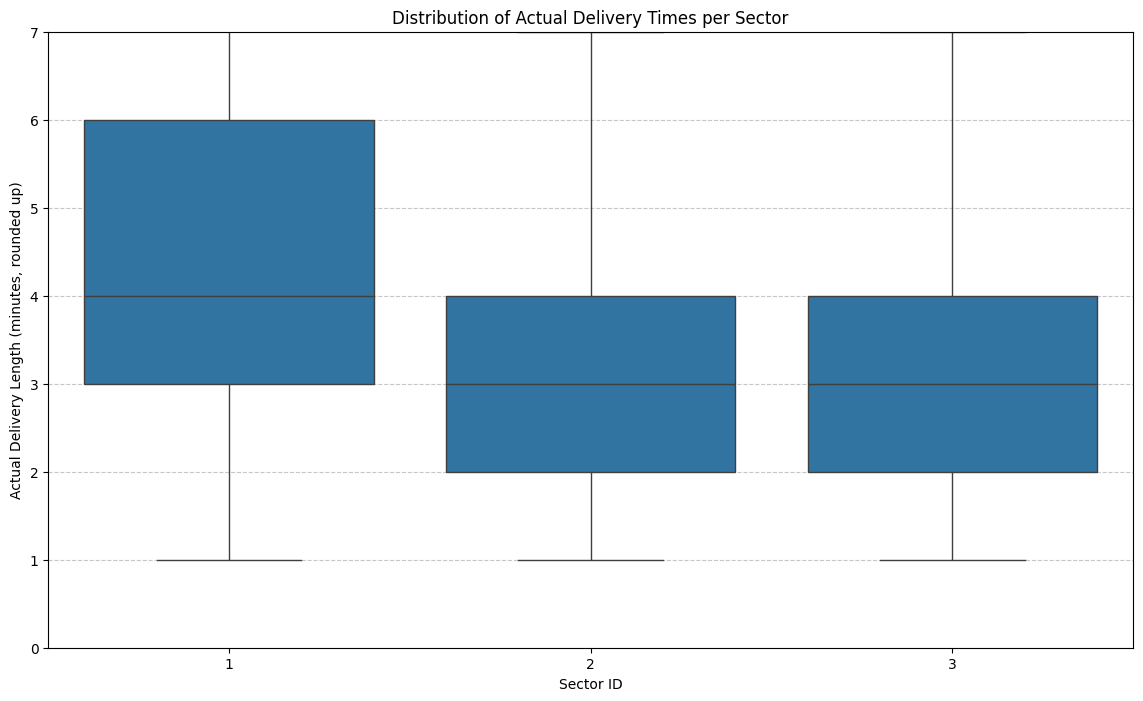

/tmp/ipykernel_6209/1699084526.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sector_times.groupby("sector_id")[
/tmp/ipykernel_6209/1699084526.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


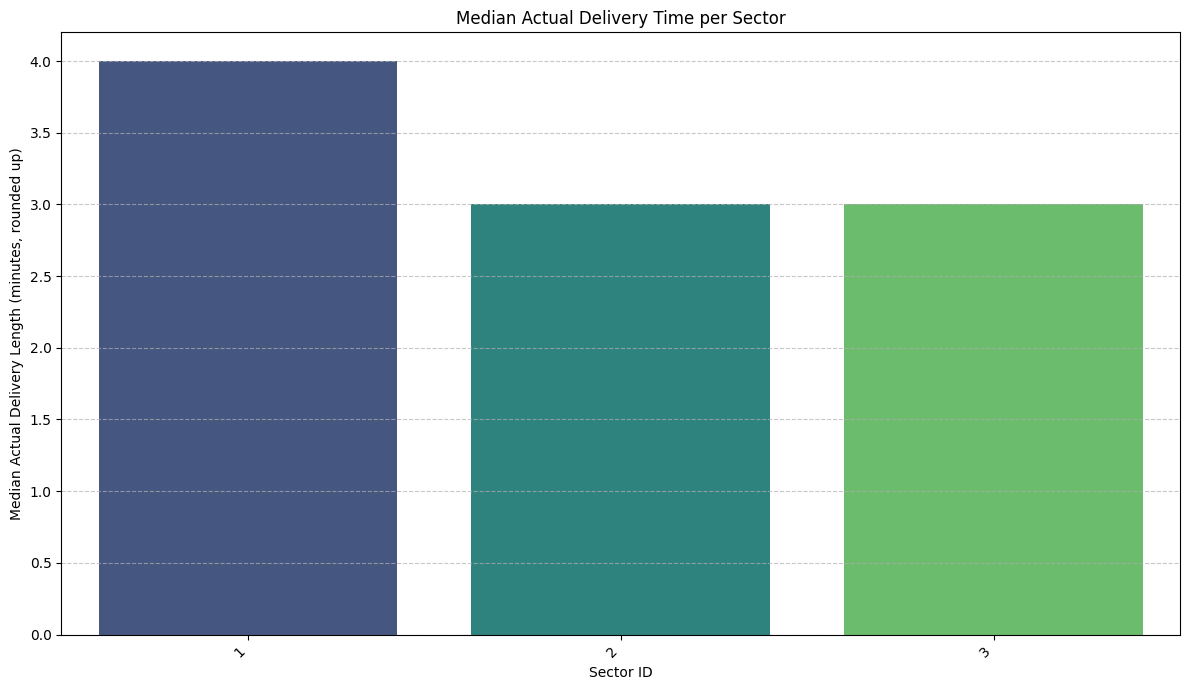

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


if "df_stops" not in globals() or "df_orders" not in globals():
    print(
        "Error: df_stops or df_orders not found. Please ensure they are loaded and processed from previous steps."
    )
else:
    df_sector_times = pd.merge(
        df_stops[["order_id", "actual_delivery_duration_minutes_rounded_up"]],
        df_orders[["order_id", "sector_id"]],
        on="order_id",
        how="inner",
    )

    print(f"\n--- Merged DataFrame for Sector Analysis (df_sector_times) ---")
    print(f"Number of records after merge: {len(df_sector_times)}")
    print(df_sector_times.head())

    if df_sector_times.empty:
        print("Merge for sector analysis resulted in an empty DataFrame.")
    else:
        df_sector_times.dropna(subset=["sector_id"], inplace=True)
        df_sector_times["sector_id"] = (
            df_sector_times["sector_id"].astype(int).astype("category")
        )

        print("\n--- Delivery Time Statistics per Sector (Minutes, Rounded Up) ---")
        sector_summary = df_sector_times.groupby("sector_id")[
            "actual_delivery_duration_minutes_rounded_up"
        ].agg(["mean", "median", "count", "std", "min", "max"])
        print(sector_summary)

        plt.figure(figsize=(14, 8))
        sns.boxplot(
            data=df_sector_times,
            x="sector_id",
            y="actual_delivery_duration_minutes_rounded_up",
            showfliers=True,
        )
        plt.title("Distribution of Actual Delivery Times per Sector")
        plt.xlabel("Sector ID")
        plt.ylabel("Actual Delivery Length (minutes, rounded up)")
        plt.grid(axis="y", linestyle="--", alpha=0.7)

        plt.ylim(
            0,
            df_sector_times["actual_delivery_duration_minutes_rounded_up"].quantile(
                0.95
            ),
        )

        plt.show()
        plt.figure(figsize=(12, 7))
        sector_median_times = (
            df_sector_times.groupby("sector_id")[
                "actual_delivery_duration_minutes_rounded_up"
            ]
            .median()
            .sort_values()
        )
        sns.barplot(
            x=sector_median_times.index, y=sector_median_times.values, palette="viridis"
        )
        plt.title("Median Actual Delivery Time per Sector")
        plt.xlabel("Sector ID")
        plt.ylabel("Median Actual Delivery Length (minutes, rounded up)")
        plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels if many sectors
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.tight_layout()
        plt.show()
        # plt.savefig('barchart_median_delivery_time_per_sector.png', dpi=300)